# WRG: Weapon Recoil Generation

## 1. 좌표 값 생성 함수 설계

In [1]:
import numpy as np

def generate_segmented_recoil(shots):
    x = []
    y = []

    for i in range(1, shots + 1):
        # 초탄
        if i <= int(shots/3):
            dx = np.random.normal(0.1, 0.05)        # 약간의 X축 흔들림 부여
            dy = np.random.uniform(0.3, 0.5)        # 세로 반동 (조금 줄임)
        # 중탄
        elif i <= int((shots/3)*2):
            dx = np.random.normal(0.3, 0.25)        # X축 미세 흔들림 증가
            dy = np.random.normal(0.3, 0.3)
        # 후탄
        else:
            dx = np.random.uniform(-1, 1)           # X축 흔들림 강함
            dy = np.random.normal(0.05, 0.02)       # Y축 거의 없음

        x.append(dx)
        y.append(dy)

    x_cum = np.cumsum(x)
    y_cum = np.cumsum(y)

    return x_cum, y_cum

## 2. 데이터 증강 및 저장 함수 설계

In [116]:
import json

def generate_recoil_dataset(shots):
    recoil_dataset = []
    for i in range(100):
        x, y = generate_segmented_recoil(shots)
        dataset = [{'x': float(xi), 'y': float(yi)} for xi, yi in zip(x, y)]
        recoil_dataset.append({
            f'INDEX': i,
            'DATA': dataset
        })

    with open ("data/recoil_segmented_dataset.json", "w", encoding="utf-8") as f:
        json.dump(recoil_dataset, f, indent=2, ensure_ascii=False)

    print("'recoil_segmented_dataset.json' 파일로 저장 완료되었습니다.")

    return x, y

## 3. 시각화 함수 설계

In [3]:
import matplotlib.pyplot as plt

def plot_recoil_pattern(x, y):
    plt.figure(figsize=(5, 5))
    plt.scatter(x, y, c='red', s=10, marker='s')  # y축 반전해서 위로 튀는 느낌
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    plt.gca().set_facecolor('white')
    plt.grid(True, linestyle=':', color='grey', alpha=0.3)
    plt.xticks(np.arange(-10, 10, 1))
    plt.yticks(np.arange(-10, 10, 1))
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.gca().set_aspect('equal')
    plt.title("Improved Recoil Pattern (30 shots)", color='black')
    plt.tick_params(colors='black')
    plt.tight_layout()
    plt.show()

## 4. 사용 예시

In [118]:
import pandas as pd

x, y = generate_recoil_dataset(30)
# plot_recoil_pattern(x, y)
df = pd.DataFrame(x, y)
df

'recoil_segmented_dataset.json' 파일로 저장 완료되었습니다.


,0
0.316053,0.084379
0.640934,0.133716
0.984225,0.290540
1.450935,0.354123
1.816876,0.529132
2.192387,0.590850
2.689334,0.688185
3.151189,0.773504
3.473188,0.871227
3.782386,0.921013


## 5. 학습 데이터 변환

In [105]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

class BulletTrajectory:
    """총알 궤적을 생성하고 전처리 및 분리하는 클래스"""
    def __init__(self):
        self.data = None
        self.X_coords = None
        self.y_coords = None

    def data_load(self, address: str):
        """데이터 로드 함수"""
        with open(address, "r", encoding="utf-8") as f:
            self.data = json.load(f)

        return self.data

    def data_preprocessing(self, raw_data):
        """데이터 전처리 함수"""
        X_coords, y_coords = [], []
        for record in raw_data:
            record_points = record["DATA"]
            X_coords.append(np.array([[point['x']] for point in record_points]))
            y_coords.append(np.array([[point['y']] for point in record_points]))
        self.X_coords = X_coords
        self.y_coords = y_coords

        return X_coords, y_coords

    def weapon_recoil_generation(self, X_coords, y_coords):
        """데이터 프레임 생성하는 함수"""
        df1 = pd.DataFrame(np.array(X_coords).reshape(100, -1))
        df2 = pd.DataFrame(np.array(y_coords).reshape(100, -1))
        X1 = df1.drop(columns=[0])
        y1 = df1[0]
        X2 = df2.drop(columns=[0])
        y2 = df2[0]

        return X1, y1, X2, y2

    def data_split(self, x, y):
        """학습 데이터와 테스트 데이터를 분리하는 함수"""
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        
        return X_train, X_test, X_val, y_train, y_test, y_val

In [106]:
trajectory = BulletTrajectory()

data = trajectory.data_load("data/recoil_segmented_dataset.json")
X, y = trajectory.data_preprocessing(data)
X1, y1, X2, y2 = trajectory.weapon_recoil_generation(X, y)
X_train, X_test, X_val, y_train, y_test, y_val = trajectory.data_split(X1, y1)

## 6. 학습 모델 설정
- 새로운 궤적 패턴 생성
- pip install scikit-learn

[목표]

모델: RandomForestRegressor

데이터: X (총기 반동 궤적 벡터, shape=(100, 59)), y (첫 번째 y 좌표)

평가지표: MSE (Mean Squared Error)

시각화: 예측값 vs 실제값 scatter plot

In [107]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import koreanize_matplotlib
import matplotlib.pyplot as plt

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")


MSE: 0.0015


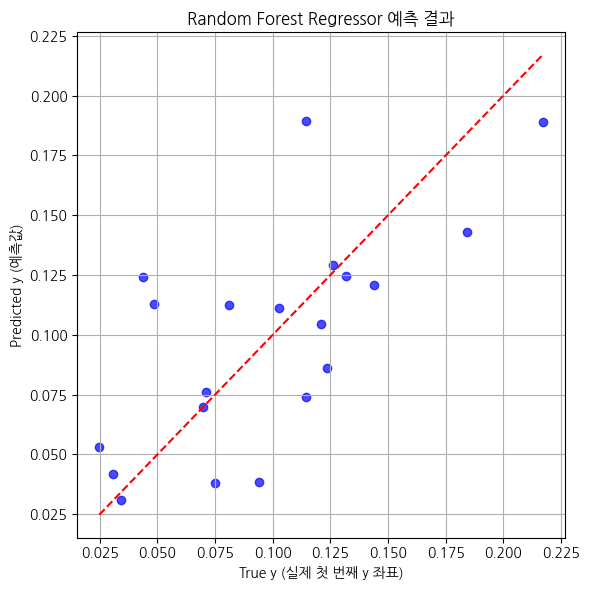

In [108]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True y (실제 첫 번째 y 좌표)")
plt.ylabel("Predicted y (예측값)")
plt.title("Random Forest Regressor 예측 결과")
plt.grid(True)
plt.tight_layout()
plt.show()